In [62]:
import pickle, gzip, math, os, time, shutil, torch, random, logging
import fastcore.all as fc, matplotlib as mpl, numpy as np, matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torchvision.transforms.functional as TF, torch.nn.functional as F
from torch import tensor, nn, optim
from torch.utils.data import DataLoader, default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from IPython import display
import pandas as pd
import seaborn as sns

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *


In [63]:
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset, load_dataset_builder

mpl.rcParams["image.cmap"] = "gray_r"
logging.disable(logging.WARNING)


## Load the dataset

In [64]:
from torchvision import transforms 


denorm_image = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2)
    ])

In [65]:
xl, yl = "image", "label"
name = "fashion_mnist"
dsd = load_dataset(name)


@inplace
def transformi(b):
    b[xl] = [F.pad(TF.to_tensor(o), (2, 2, 2, 2))*2-1 for o in b[xl]]


bs = 128
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=0)

  0%|          | 0/2 [00:00<?, ?it/s]

In [66]:
dt = dls.train
xb, yb = next(iter(dt))


In [72]:
xb.min(), xb.max()

(tensor(-1.), tensor(1.))

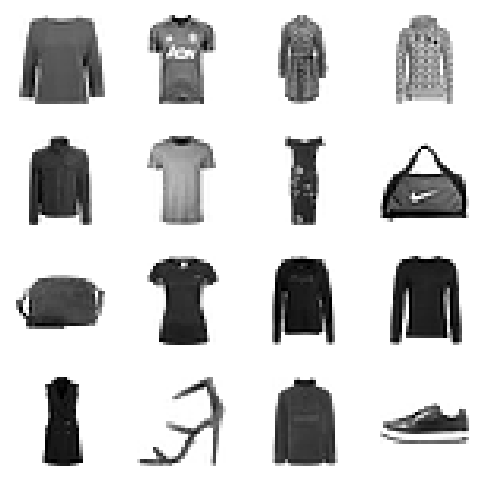

In [74]:
show_images(denorm_image(xb[:16]), imsize=1.5)

In [75]:
from types import SimpleNamespace

def abar(t, T): return (t/T*math.pi/2).cos()**2


def cos_sched(n_steps=1000):
    ts = torch.linspace(0, n_steps-1, n_steps)
    ab = abar(ts,n_steps)
    alp = ab/abar(ts-1,n_steps)
    return SimpleNamespace(a=alp, abar=ab, sig=(1-alp).sqrt())

n_steps = 1000
lin_abar = cos_sched()
alphabar = lin_abar.abar
alpha = lin_abar.a
sigma = lin_abar.sig

<Axes: >

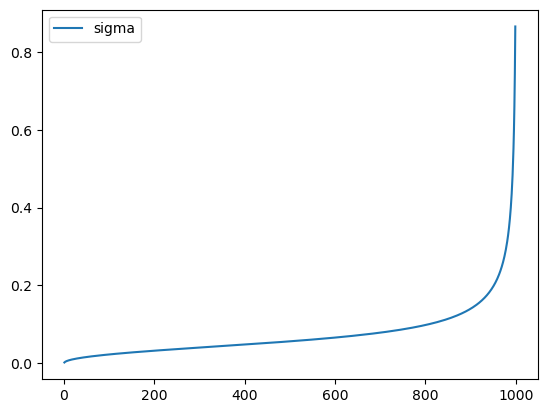

In [76]:
sns.lineplot(sigma, label="sigma")

<Axes: >

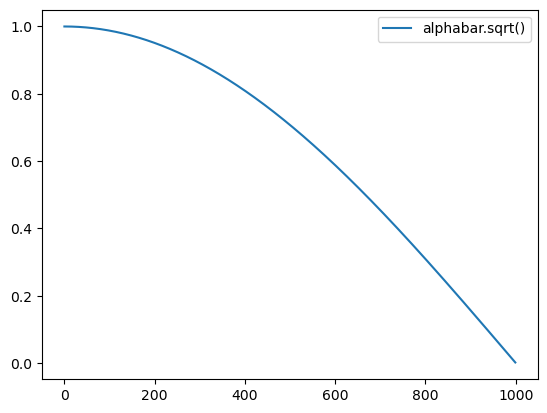

In [86]:
sns.lineplot(alphabar.sqrt(), label="alphabar.sqrt()")

In [87]:
def noisify(x0, ᾱ):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt() * x0 + (1 - ᾱ_t).sqrt() * ε
    return (xt, t.to(device)), ε


## Training

In [88]:
from diffusers import UNet2DModel

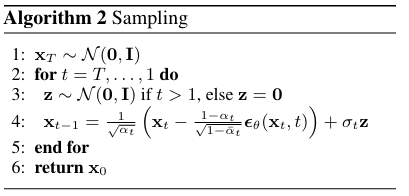

In [89]:
display.Image(
    "images/ddpm_sampling_algo_2.png"
)

Added Algorithm 2 from DDPM paper - notice how it differs from the "miniai version"



In [90]:
class UNet(UNet2DModel):
    def forward(self, x):
        return super().forward(*x).sample


In [91]:
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

In [92]:
def collate_ddpm(b):
    return noisify(default_collate(b)[xl], alphabar)


def dl_ddpm(ds, nw=0):
    return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=nw)

In [93]:
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))


In [94]:
lr = 1e-2
epochs = 5
opt_func = partial(optim.AdamW, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [TrainCB(), DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
model = UNet(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 256), norm_num_groups=8)
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.125,0,train
0.074,0,eval
0.068,1,train
0.065,1,eval
0.062,2,train
0.061,2,eval
0.058,3,train
0.057,3,eval
0.055,4,train
0.056,4,eval


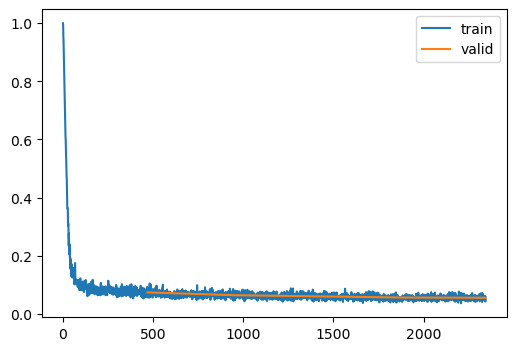

In [95]:
learn.fit(epochs)


In [96]:
mdl_path = Path('models')


In [97]:
torch.save(learn.model, mdl_path/'fashion_ddpm_cos_5.pkl')


In [98]:
learn.model = torch.load(mdl_path / "fashion_ddpm_cos_5.pkl").to("mps")

In [99]:
@torch.no_grad()
def sample_algorithm_2(model, sz, alpha, alphabar, sigma, n_steps):
    device = next(model.parameters()).device
    x_t = torch.randn(sz, device=device)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)

        noise_pred = model((x_t, t_batch))

        # line 4
        x_t_minus_1 = (1.0 / alpha[t]).sqrt() * (
            x_t - ((1 - alpha[t]) / ((1.0 - alphabar)[t].sqrt())) * noise_pred
        ) + sigma[t] * z

        x_t = x_t_minus_1

        preds.append(x_t_minus_1)
    return preds

In [101]:
rez = sample_algorithm_2(learn.model, (16, 1, 32, 32), alpha, alphabar, sigma, 1000)

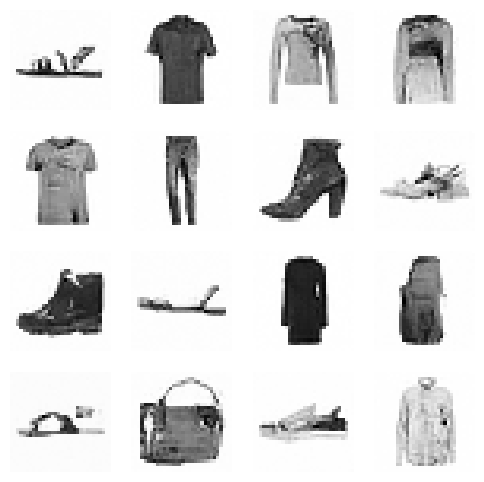

In [106]:
# TODO: check why the last images are all nan's
show_images(denorm_image(rez[-2]), imsize=1.5)